In [9]:
#importing the os module
import os

#to get the current working directory
directory = os.getcwd()

print(directory)

D:\Git stuff\Tiriamiasis_Projektas_2


In [12]:
os.chdir("D:\Git stuff\Tiriamiasis_Projektas_2")

#to get the current working directory
directory = os.getcwd()

print(directory)

D:\Git stuff\Tiriamiasis_Projektas_2


In [13]:
import os, shutil, json
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from numpy import reshape, expand_dims

In [33]:
GRID_SIZE = 8
VECTOR_LENGTH = GRID_SIZE * GRID_SIZE
CHANNELS = 1

if not(os.path.isdir('logs')):
    os.mkdir('logs')

In [ ]:
# the format of .mat files:
# if, for example, we have 8x8 permeability map, then in the .mat file the first row will represent one map and
# the matrix has been expanded from 2D into 1D in such a way: 1 row + 2 row + 3 row + ... + 8 row.

In [21]:
permeability = loadmat('Data/8x8_permeability.mat')
permeability = pd.DataFrame(normalize(permeability['permeability']))

target = loadmat('Data/8x8_target.mat')
target = pd.DataFrame(normalize(target['target']))

perm_train, perm_test, target_train, target_test = train_test_split(permeability, target, test_size = 0.2, random_state = 0)

In [22]:
permeability.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.199659,0.115416,0.050238,0.025786,0.015202,0.012305,0.014853,0.019189,0.185316,0.127507,...,0.258354,0.202175,0.005747,0.013874,0.044360,0.094783,0.186798,0.262451,0.330029,0.292219
1,0.167853,0.194822,0.154417,0.039611,0.015253,0.010435,0.018738,0.026319,0.113427,0.128126,...,0.075490,0.258073,0.703169,0.282415,0.088895,0.015269,0.007818,0.009022,0.049790,0.205278
2,0.113959,0.083395,0.058175,0.050660,0.071669,0.103677,0.116228,0.091104,0.260020,0.159634,...,0.037610,0.032172,0.036305,0.079707,0.118178,0.062429,0.040089,0.034362,0.026050,0.013860
3,0.089966,0.054167,0.019384,0.014667,0.007418,0.009287,0.008159,0.010806,0.049204,0.039356,...,0.197972,0.270326,0.143766,0.104241,0.089491,0.077015,0.095146,0.103336,0.148344,0.198407
4,0.041318,0.170778,0.382746,0.285647,0.111765,0.104633,0.086261,0.086201,0.068166,0.165140,...,0.087252,0.059907,0.031528,0.039254,0.066587,0.094168,0.155126,0.152694,0.172267,0.150526


In [23]:
# palyginimui tiesines regresijos MSE ir MAE

lin_reg = LinearRegression(n_jobs = -1)
lin_reg.fit(perm_train, target_train, )

predicted_target = lin_reg.predict(perm_test)
MSE = mean_squared_error(target_test, predicted_target)
MAE = mean_absolute_error(target_test, predicted_target)

print(MSE, MAE)

0.0002839440308775823 0.009701995924924073


In [35]:
def clear_model_logs(model_name):
    folder = 'logs/' + model_name
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
            
def save_extra_info(optimizer, batch_size, model, model_name):
    if not(os.path.isdir('logs/' + model_name)):
        os.mkdir('logs/' + model_name)
    
    supp_info = tf.keras.optimizers.serialize(optimizer)
    supp_info["batch_size"] = str(batch_size)
    supp_info["data_size"] = str(sqrt(VECTOR_LENGTH))
    supp_info["train_set_size"] = str(perm_train.shape[0])
    supp_info["test_set_size"] = str(perm_test.shape[0])
    supp_info["model"] = model.to_json()
    
    open('logs/' + model_name + '/' + model_name + '.json', 'w').write(json.dumps(supp_info, indent = 4))
    
def fit_model(optimizer, batch_size, model, model_name, epochs):
    save_extra_info(optimizer, batch_size, model, model_name)

    history = model.fit(x = perm_train, y = target_train, batch_size = batch_size, epochs = epochs, verbose = 0, 
              validation_data = (perm_test, target_test), shuffle = True)

    history = pd.DataFrame.from_dict(history.history)
    history.to_csv('logs/' + model_name + '/' + model_name + '.csv', index = False)
    model.save('logs/' + model_name, save_format = "tf")
    
def load_model(model_name, optimizer):
    model = tf.keras.models.load_model(filepath = 'logs/' + model_name, compile = False)
    model.compile(optimizer = optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

def FF1(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(32, activation = 'relu', input_shape = (VECTOR_LENGTH, )))
    model.add(tf.keras.layers.Dense(32, activation = 'relu'))
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mean_absolute_error']) 
    return model

def FF2(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(16, activation = 'relu', input_shape = (VECTOR_LENGTH, )))
    model.add(tf.keras.layers.Dense(16, activation = 'relu'))
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mean_absolute_error']) 
    return model

def FF3(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(8, activation = 'relu', input_shape = (VECTOR_LENGTH, )))
    model.add(tf.keras.layers.Dense(8, activation = 'relu'))
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mean_absolute_error']) 
    return model

def FF4(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(16, activation = 'relu', input_shape = (VECTOR_LENGTH, )))
    model.add(tf.keras.layers.Dense(16, activation = 'relu'))
    model.add(tf.keras.layers.Dense(16, activation = 'relu'))
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mean_absolute_error']) 
    return model

def FF5(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(32, activation = 'linear', input_shape = (VECTOR_LENGTH, )))
    model.add(tf.keras.layers.Dense(32, activation = 'linear'))
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mean_absolute_error']) 
    return model

def CNN1(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Reshape((GRID_SIZE, GRID_SIZE, CHANNELS), input_shape=(VECTOR_LENGTH,)))
    model.add(tf.keras.layers.Conv2D(filters = 4, kernel_size = (3,3), activation = 'relu', input_shape = (GRID_SIZE, GRID_SIZE, CHANNELS)))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mean_absolute_error']) 
    return model

def CNN1(optimizer):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Reshape((GRID_SIZE, GRID_SIZE, CHANNELS), input_shape=(VECTOR_LENGTH,)))
    model.add(tf.keras.layers.Conv2D(filters = 4, kernel_size = (3,3), activation = 'relu', input_shape = (GRID_SIZE, GRID_SIZE, CHANNELS)))
    model.add(tf.keras.layers.MaxPool2D(pool_size = 3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(VECTOR_LENGTH, activation = 'linear'))
    model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mean_absolute_error']) 
    return model

In [38]:
# launch model experiments

batch_size = 100
learning_rate = 0.00001
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

model_name = 'CNN1'
#model = FF1(optimizer)
#model = load_model('FF1', optimizer)
model = CNN1(optimizer)
fit_model(optimizer, batch_size, model, model_name, epochs = 1500)

INFO:tensorflow:Assets written to: logs/CNN1\assets


0.0008047630544751 0.000962596212048
0.0186336264014244 0.0197122972458601


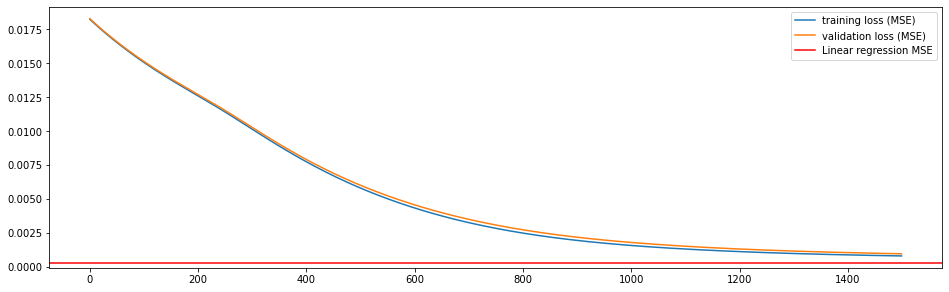

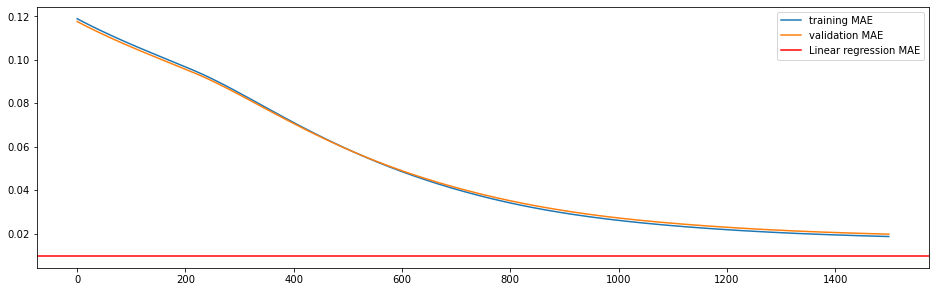

In [39]:
# siuo metu maziausi val error pasiekti su FF1:
# MSE = 0.0001727994531393 ir MAE = 0.0079095419496297
#model_name = 'FF1v2'
history = pd.read_csv('logs/' + model_name + '/' + model_name + '.csv')

plt.figure(figsize = (16, 4.8))
plt.plot(history["loss"], label = "training loss (MSE)")
plt.plot(history["val_loss"], label = "validation loss (MSE)")
plt.axhline(y = MSE, color = 'r', linestyle = '-', label = 'Linear regression MSE')
plt.legend(loc = 'upper right')
print("{:.16f}".format(min(history["loss"])), min(history["val_loss"]))


plt.figure(figsize = (16, 4.8))
plt.plot(history["mean_absolute_error"], label = "training MAE")
plt.plot(history["val_mean_absolute_error"], label = "validation MAE")
plt.axhline(y = MAE, color = 'r', linestyle = '-', label = 'Linear regression MAE')
plt.legend(loc = 'upper right')
print(min(history["mean_absolute_error"]), min(history["val_mean_absolute_error"]))

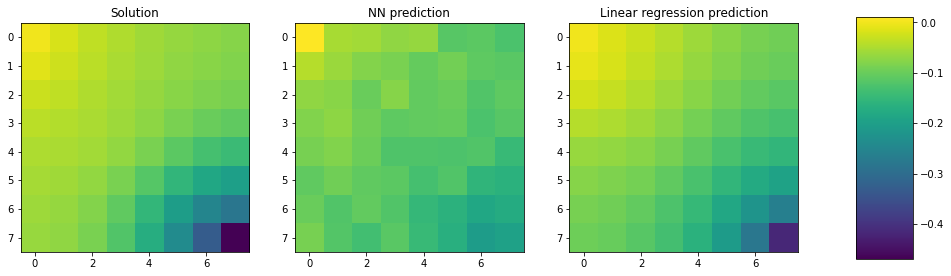

In [40]:
map_index = 1

dummy_rate = 0.0001
dummy_optimizer = tf.keras.optimizers.Adam(learning_rate = dummy_rate)
#model = load_model('FF1v2', dummy_optimizer)
model = load_model(model_name, dummy_optimizer)

perm_test_sample = perm_test.iloc[map_index].to_numpy()

test_prediction = model.predict(expand_dims(perm_test_sample, 0), batch_size = 1)
test_prediction = reshape(test_prediction, (int(sqrt(VECTOR_LENGTH)), int(sqrt(VECTOR_LENGTH))))

lin_reg_prediction = lin_reg.predict(perm_test_sample.reshape(1, -1))
lin_reg_prediction = reshape(lin_reg_prediction, (int(sqrt(VECTOR_LENGTH)), int(sqrt(VECTOR_LENGTH))))

test_solution = reshape(target_test.iloc[map_index].to_numpy(), (int(sqrt(VECTOR_LENGTH)), int(sqrt(VECTOR_LENGTH))))



cm_range = [min(min(test_solution.flatten()), min(test_prediction.flatten()), min(lin_reg_prediction.flatten())), 
            max(max(test_solution.flatten()), max(test_prediction.flatten()), max(lin_reg_prediction.flatten()))]

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 4.8))
im = axes[0].imshow(test_solution, vmin = cm_range[0], vmax = cm_range[1])
axes[0].title.set_text('Solution')
im = axes[1].imshow(test_prediction, vmin = cm_range[0], vmax = cm_range[1])
axes[1].title.set_text('NN prediction')
im = axes[2].imshow(lin_reg_prediction, vmin = cm_range[0], vmax = cm_range[1])
axes[2].title.set_text('Linear regression prediction')

fig.subplots_adjust(right = 0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [41]:
# review model architecture

learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
#model = FF1(optimizer)
model = CNN1(optimizer)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_5 (Reshape)         (None, 8, 8, 1)           0         
                                                                 
 conv2d_4 (Conv2D)           (None, 6, 6, 4)           40        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 4)          0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                1088      
                                                                 
Total params: 1,128
Trainable params: 1,128
Non-trainable params: 0
____________________________________________________

In [ ]:
# paklaust ar duomenu normalizavimas iskreipia permeability?
# pabandyt permeability performuot is vektoriaus i matrica ir praleist per convolution?

In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir logs/test
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = "logs/" + model_name, write_graph = False)

#f = open('sample.json')
#data = json.load(f)
#data['model']
#mod = tf.keras.models.model_from_json(data['model'])